In [17]:
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

# ---
thisrun = "liming_noFert_hist_tph7p1_site_311_1950-2020_startyear-4p0_iter-2_field"
thisrun = "liming_noFert_hist_tph7p1_site_411_1950-2020_startyear-0_iter-0_field"
outdir = "/home/tykukla/SCEPTER/scepter_output"

In [18]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [19]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine


# where results are stored
results_path = os.path.join(outdir, thisrun)
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(
    results_path, "prof"
)

# define file name pattern
fn_pref = ["prof_aq"]  #  ["prof_aq"] # ["prof_aq", "prof_sld(wt%)"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")
    file_paths_numsOnly = [
        path for path in file_paths if re.search(r"\d", path.split("/")[-1])
    ]
    # filter edge case of "prof_aq-DIC-020.txt"
    if "prof_aq-DIC-020.txt" in file_paths_numsOnly:
        file_paths_numsOnly = file_paths_numsOnly.remove("prof-restart")
    # read in data and concatenate
    for file_path in file_paths_numsOnly:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,ca,k,mg,na,no3,ph,time,var,8.333333333333333218e-03,1.234303636429814411e-03
90,0.008333,0.000007,2.573097e-21,6.557857e-22,2.778482e-21,0.000026,4.865130,0.000018,prof_aq,NaN,NaN
91,0.025000,0.000014,3.705079e-21,1.378013e-21,3.680279e-21,0.000042,4.702953,0.000018,prof_aq,NaN,NaN
92,0.041667,0.000021,4.552715e-21,2.079483e-21,4.525075e-21,0.000058,4.613605,0.000018,prof_aq,NaN,NaN
93,0.058333,0.000029,5.258662e-21,2.773675e-21,5.233874e-21,0.000074,4.551055,0.000018,prof_aq,NaN,NaN
94,0.075000,0.000036,5.876289e-21,3.462957e-21,5.853612e-21,0.000089,4.502859,0.000018,prof_aq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prof_aq,0.425000,0.000457
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prof_aq,0.441667,0.000457
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prof_aq,0.458333,0.000457
207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prof_aq,0.475000,0.000457


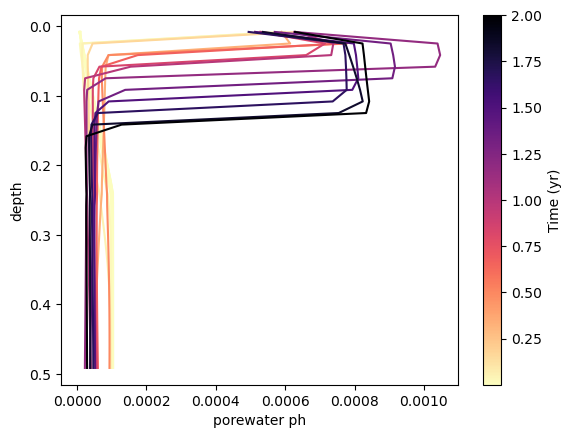

In [20]:
# --- plot depth profile of calcite through time
dfx = df[df["var"] == "prof_aq"]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby("time")

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    plt.plot(group["ca"], group["z"], color=color, label=None)
    # plt.plot(group['gt'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and a legend
plt.xlabel("porewater ph")
plt.ylabel("depth")
# plt.ylim(0,0.1)

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [35]:
# --- CLIMATE CHECK
# --- function to preprocess clim .in files


def read_cust_delim_file(file_path):
    # Read the first line to get column names using '/'
    with open(file_path) as file:
        # columns = file.readline().strip().split(' / ')
        columns = file.readline().strip().split("\t")

    # Read the rest of the file using '\t' as the data delimiter
    df = pd.read_table(file_path, names=columns, delimiter="\t", skiprows=[0])

    # --- clean up column names
    # Remove "# " prefix from column headers
    df.columns = df.columns.str.replace("# ", "")
    # Replace parentheses with underscores
    df.columns = map(lambda x: x.replace("(", "_").replace(")", ""), df.columns)
    # replace "/" with underscores
    df.columns = map(lambda x: x.replace("/", "_"), df.columns)
    # remove leading or trailing spaces
    df.columns = df.columns.str.strip()
    # return
    return df

In [5]:
# --- read in data
fnvars = ["T", "q", "Wet"]
fnsuff = "_temp.in"

# loop through vars
dfclim = pd.DataFrame()
for var in fnvars:
    thisvar = var + fnsuff
    dfi = read_cust_delim_file(os.path.join(results_path, thisvar))
    # bring together
    if var == fnvars[0]:
        dfclim = dfi.copy()
    else:
        dfclim = pd.merge(dfclim, dfi, on="time_yr", how="outer")

dfclim

,time_yr,T_C,runoff_mm_month,moisture_mm_m
0,0.000000,-2.313202,21.824619,330.569153
1,0.083361,-9.621094,20.971416,346.428528
2,0.166722,-13.380249,15.529438,346.429718
3,0.250083,-4.583283,48.184877,346.430237
4,0.333444,11.897552,42.839510,382.678436
...,...,...,...,...
847,70.606775,25.961121,9.390303,247.329086
848,70.690136,27.792053,14.495633,253.312744
849,70.773497,24.515289,12.734972,308.044769
850,70.856858,16.634216,11.910278,309.311890


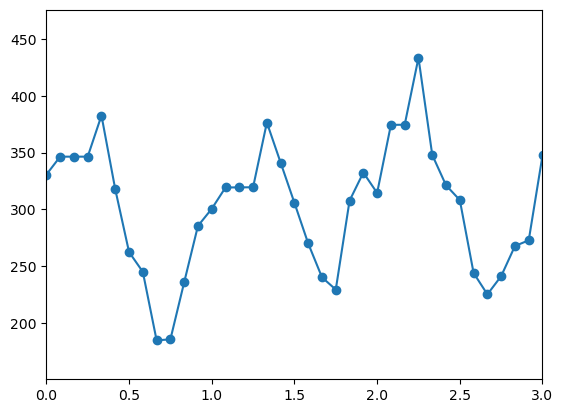

In [6]:
# --- quick plot, a few seasons
pvar = "moisture_mm_m"  # runoff_mm_month
# T_C
# moisture_mm_m

# plot
plt.plot(dfclim["time_yr"], dfclim[pvar])
plt.scatter(dfclim["time_yr"], dfclim[pvar])
plt.xlim([0, 3])
plt.show();

In [7]:
# --- flux data
results_path = outdir
results_dir = {"test": thisrun}
# define file name pattern
# fn_pref = ["int_flx_co2sp", "flx_co2sp" "int_flx_gas", "flx_gas"]   # will read in all species unless fn_varInclude is defined
fn_pref = [
    "flx_aq-ca"
]  # ["flx_gas-pco2"]   # will read in all species unless fn_varInclude is defined
fn_varInclude = []
varCheck = True if len(fn_varInclude) > 0 else False
fn_ext = ".txt"

# loop through runs
df = pd.DataFrame()  # initialize empty df to store dat
for key, run in results_dir.items():
    # get these paths
    flx_path, prof_path = os.path.join(results_path, run, "flx"), os.path.join(
        results_path, run, "prof"
    )

    # loop through variables
    for fset in fn_pref:
        # set pattern
        fn_pattern = f"{fset}*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

        # read in data and concatenate
        for file_path in file_paths:
            # get the variable
            varpattern = re.escape(fset) + r"(.*?).txt"
            varmatch = re.search(varpattern, file_path)
            var = varmatch.group(1)
            # skip this step if it's not in the include arr
            if varCheck:
                if var not in fn_varInclude:
                    continue
            # read in
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add set, var, and key
            dfi["set"] = fset
            dfi["var"] = var
            dfi["run_id"] = key
            # combine
            df = pd.concat([df, dfi], ignore_index=True)

# sort by time and depth
df = df.sort_values(by=["var", "time"])
df

,time,tflx,adv,dif,rain,cc,inrt,g2,amnt,cc,...,gb,ct,cabd,ill,gps,mgbd,res,set,var,run_id
0,1.000000e-19,53415.283333,0.004083,1.025177e-15,0.0,-8.155324e-17,0.0,0.0,0.0,-4.928457e-14,...,0.0,0.0,-1.844747e-22,0.0,-2.964790e-15,0.0,5.341529e+04,flx_aq-ca,,test
1,1.766667e-05,0.082156,0.004087,1.039972e-15,0.0,-4.312124e-02,0.0,0.0,0.0,-4.312124e-02,...,0.0,0.0,-1.844578e-22,0.0,-6.067149e-16,0.0,7.319802e-10,flx_aq-ca,,test
2,5.100000e-05,0.318163,0.004094,1.080682e-15,0.0,-1.611286e-01,0.0,0.0,0.0,-1.611286e-01,...,0.0,0.0,-1.843295e-22,0.0,-1.428567e-16,0.0,8.137108e-11,flx_aq-ca,,test
3,1.676667e-04,1.737142,0.004098,4.737510e-16,0.0,-8.706200e-01,0.0,0.0,0.0,-8.706200e-01,...,0.0,0.0,-1.839449e-22,0.0,-4.232966e-17,0.0,-3.120078e-11,flx_aq-ca,,test
4,5.010000e-04,5.569597,0.003755,8.937248e-16,0.0,-2.786676e+00,0.0,0.0,0.0,-2.786676e+00,...,0.0,0.0,-1.830924e-22,0.0,-1.500847e-17,0.0,-7.231445e-11,flx_aq-ca,,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1.833334e+00,-0.061430,0.061430,1.076376e-15,0.0,-6.396958e-19,0.0,0.0,0.0,-6.396958e-19,...,0.0,0.0,-3.711448e-22,0.0,-2.037581e-17,0.0,6.245708e-11,flx_aq-ca,,test
83,1.850007e+00,-0.053801,0.053801,-4.823412e-16,0.0,-6.341063e-19,0.0,0.0,0.0,-6.341063e-19,...,0.0,0.0,-3.458628e-22,0.0,-2.037465e-17,0.0,2.005658e-13,flx_aq-ca,,test
84,1.916668e+00,-0.039065,0.039065,-2.517585e-16,0.0,-6.347608e-19,0.0,0.0,0.0,-6.347608e-19,...,0.0,0.0,-2.627062e-22,0.0,-5.469495e-17,0.0,-4.108765e-13,flx_aq-ca,,test
85,1.933340e+00,-0.037820,0.037820,4.961800e-16,0.0,-6.269029e-19,0.0,0.0,0.0,-6.269029e-19,...,0.0,0.0,-2.450278e-22,0.0,-5.469381e-17,0.0,-1.545776e-13,flx_aq-ca,,test


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


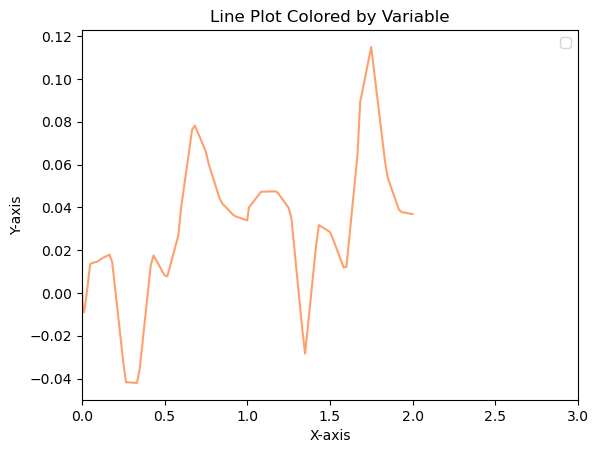

In [9]:
# --- plot CDR per year (lines colored by the set)
cdvar = "adv"  # variable to plot

# aesthetics
logX = False
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# ax limits
xmin, xmax = 0, 3

# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
# split by set
plt.plot(df["time"], df[cdvar], color=cmap(0.2), linestyle="-")

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.0001, 15])
plt.title("Line Plot Colored by Variable")
plt.xlim([xmin, xmax])
# Add legend
plt.legend()
plt.show();